# ADS Project 1: Lyrics

In [188]:
# Basic 
import pandas as pd
import numpy as np
import pprint

# Text
import nltk, re, string
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import gensim.corpora as corpora


nltk.download('punkt')
nltk.download('stopwords')

# Plot
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
%matplotlib inline  

[nltk_data] Downloading package punkt to C:\Users\Jiyoung
[nltk_data]     Sim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jiyoung
[nltk_data]     Sim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
lyrics = pd.read_csv('lyrics.csv')
lyrics.head()

,song,year,artist,genre,lyrics
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\nyou hold my han...


In [3]:
lyrics['decade'] = lyrics['year']//10*10

In [4]:
lyrics['genre'].unique()

array(['Hip-Hop', 'Other', 'Pop', 'Metal', 'Rock', 'Country', 'Indie',
       'Jazz', 'Not Available', 'Electronic', 'R&B', 'Folk'], dtype=object)

In [5]:
np.sort(lyrics['decade'].unique())

array([ 110,  700, 1960, 1970, 1980, 1990, 2000, 2010], dtype=int64)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

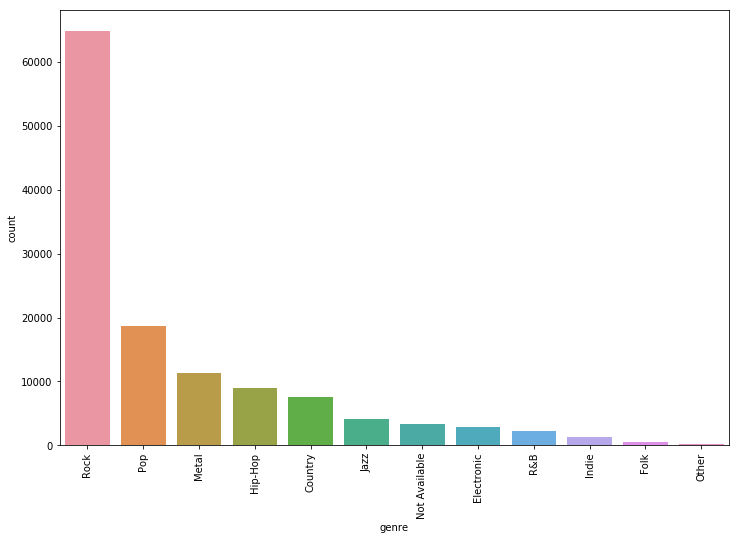

In [6]:
fig, axes = plt.subplots(1,1, figsize= (12,8))

sns.countplot(lyrics['genre'], order = lyrics['genre'].value_counts().index)
plt.xticks(rotation = 90)

In [7]:
lyrics.groupby(['decade','genre']).count()['song']

decade  genre        
110     Hip-Hop              1
700     Hip-Hop              1
1960    Rock                 1
1970    Country             49
        Electronic           9
        Folk                10
        Jazz                80
        Not Available       65
        Other                5
        Pop                163
        R&B                 65
        Rock               778
1980    Country             20
        Electronic          14
        Hip-Hop             11
        Jazz                92
        Metal               63
        Not Available       12
        Other               13
        Pop                210
        R&B                 67
        Rock               678
1990    Country            219
        Electronic          44
        Folk                27
        Hip-Hop            254
        Jazz               186
        Metal              184
        Not Available      149
        Other                5
        Pop                478
        R&B      

In [75]:
genre_keys = ['Rock', 'Pop', 'Metal', 'Hip-Hop', 'Country','Jazz', 'Electronic','R&B','Indie','Folk']
decade_keys = [1970, 1980, 1990, 2000, 2010]

Text(0.5, 1.0, 'Percentage of Each Genre by Decade')

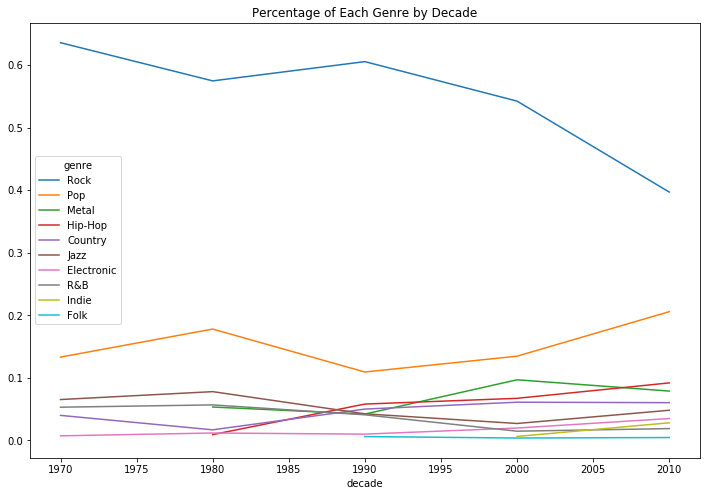

In [79]:
fig, axes = plt.subplots(1,1, figsize= (12,8))
genres_by_year = lyrics.groupby(['decade','genre']).count()['song'].drop([110,700,1960]) / lyrics.groupby(['decade'])['song'].count().drop([110,700,1960])
genres_by_year.unstack()[genre_keys].plot(ax = axes)
plt.title('Percentage of Each Genre by Decade')

In [9]:
stemmer = PorterStemmer()

def tokenize_and_stem(text):
    lowers = text.lower()
    tokens = [word for sent in nltk.sent_tokenize(lowers) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and not token in stopwords.words('english'):
            filtered_tokens.append(re.sub(r'[^\w\s]','',token))
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
    #return filtered_tokens

In [10]:
# stemmed_lyrics = [tokenize_and_stem(song) for song in lyrics['lyrics']]
stemmed_lyrics = pd.read_csv('stemmed lyrics.csv', header = None)

In [11]:
lyrics['stemmed lyrics'] = stemmed_lyrics
lyrics.head()

,song,year,artist,genre,lyrics,decade,stemmed lyrics
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...,2000,stop hous call home littl rundown grass overgr...
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,2000,feel unsur take hand lead danc floor music die...
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,2000,mark sunday footbal got boot pitch peopl gambl...
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,2000,chri fallin fantasi threw away destini nt know...
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\nyou hold my han...,2000,someth way touch hold hand hold back much some...


In [80]:
genre_groups = lyrics.groupby(['genre'])
decade_groups = lyrics.groupby(['decade'])

In [153]:
texts_genre = [' '.join(genre_groups.get_group(key)['stemmed lyrics'].tolist()) for key in genre_keys]

tfidf_vectorizer_genre = TfidfVectorizer(decode_error='ignore')
tfidf_matrix_genre = tfidf_vectorizer_genre.fit_transform(texts_genre)
   # The above line can take some time (about < 60 seconds)
feature_names_genre = tfidf_vectorizer_genre.get_feature_names()

In [102]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_idx, top_n=25):
    row = np.squeeze(X[row_idx].toarray())
    return top_tfidf_feats(row, features, top_n)

[ TF-IDF Scores by Genre ]


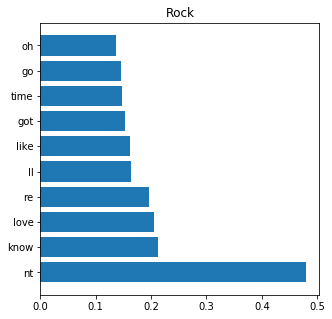

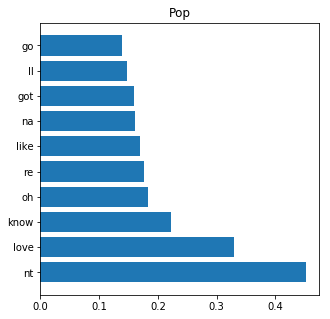

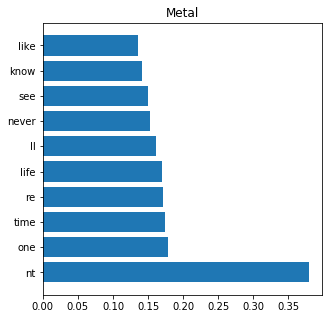

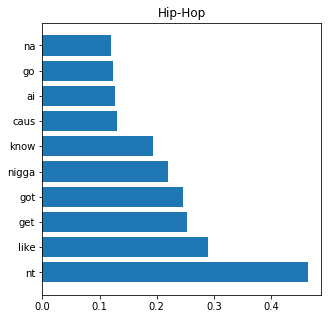

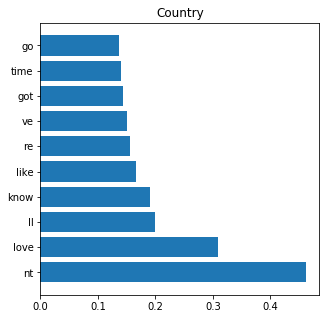

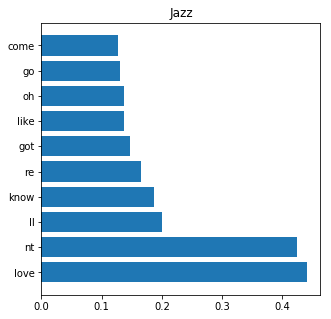

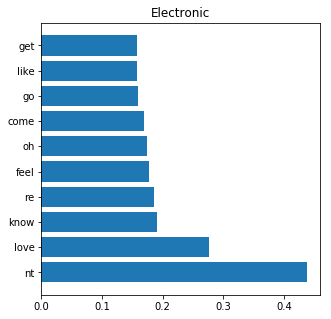

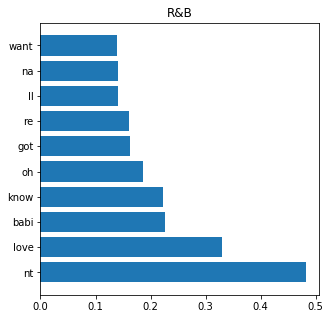

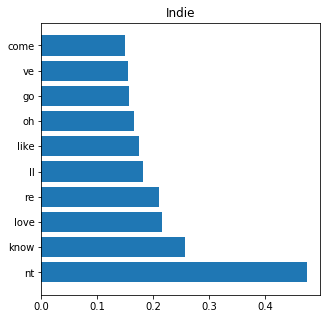

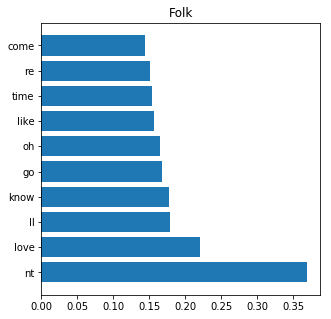

In [130]:
print("[ TF-IDF Scores by Genre ]")
for i in range(len(genre_keys)):
    plt.subplots(1,1, figsize = (5,5))
    top_feats_genre = top_feats_in_doc(tfidf_matrix_genre, feature_names_genre, i, 10)
    plt.barh(top_feats_genre['features'], top_feats_genre['score'])
    plt.title(genre_keys[i])

In [154]:
texts_decade = [' '.join(decade_groups.get_group(key)['stemmed lyrics'].tolist()) for key in decade_keys]

tfidf_vectorizer_decade = TfidfVectorizer(decode_error='ignore')
tfidf_matrix_decade = tfidf_vectorizer_decade.fit_transform(texts_decade)
   # The above line can take some time (about < 60 seconds)
feature_names_decade = tfidf_vectorizer_decade.get_feature_names()

[ TF-IDF Scores by Decade ]


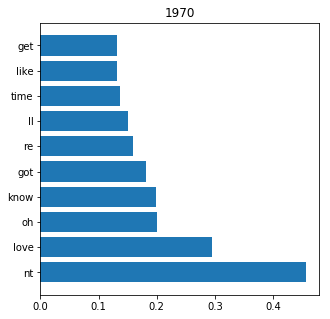

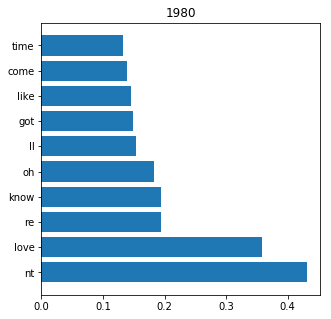

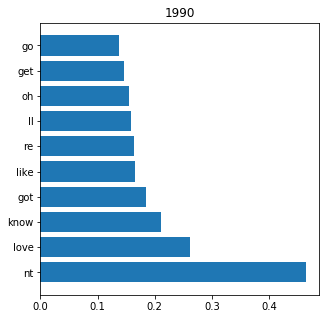

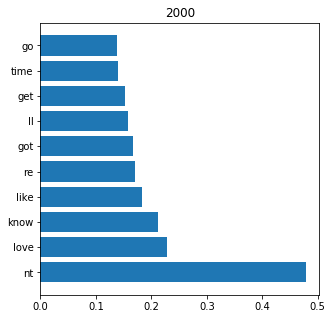

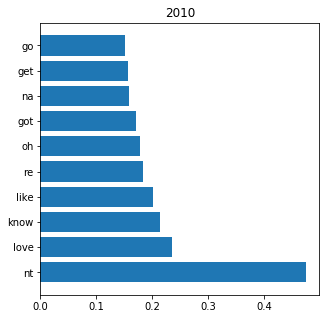

In [133]:
print("[ TF-IDF Scores by Decade ]")
for i in range(len(decade_keys)):
    plt.subplots(1,1, figsize = (5,5))
    top_feats_decade = top_feats_in_doc(tfidf_matrix_decade, feature_names_decade, i, 10)
    plt.barh(top_feats_decade['features'], top_feats_decade['score'])
    plt.title(decade_keys[i])

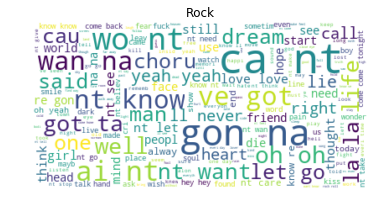

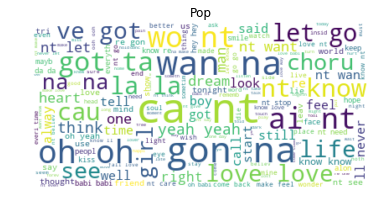

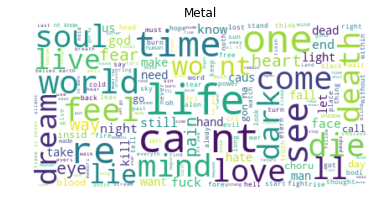

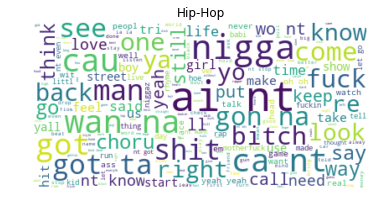

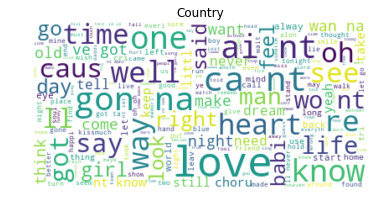

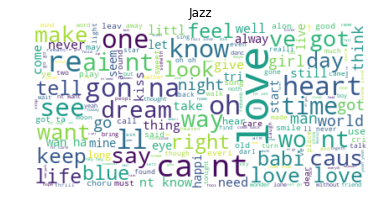

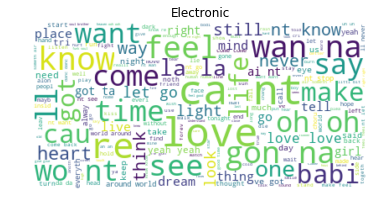

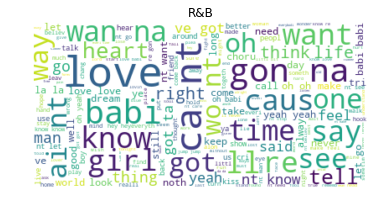

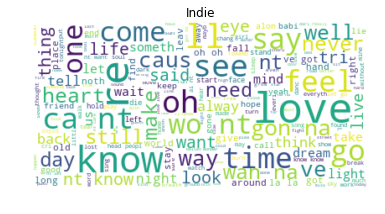

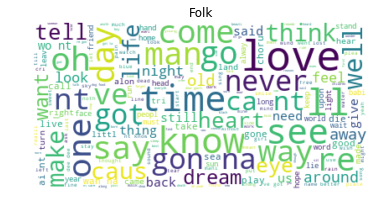

In [134]:
for key in genre_keys:
    genre = genre_groups.get_group(key)
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(' '.join(genre['stemmed lyrics'].tolist()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(key)
    plt.axis("off")
    plt.show()

In [60]:
for key in genre_keys:
    genre = genre_groups.get_group(key)
    texts = [nltk.word_tokenize(song) for song in genre['stemmed lyrics']]
    word_dictionary = corpora.Dictionary(texts)
    for idx, val in enumerate(word_dictionary): word_dictionary[idx]
    dt_matrix = [word_dictionary.doc2bow(text) for text in texts]  # Tuple (Term ID, Term Frequency)
    ldamodel = gensim.models.ldamodel.LdaModel(dt_matrix, num_topics=10, id2word=word_dictionary.id2token, passes=20)
    print("\n[ Genre: ",key," ]")
#     print("[ ldamodel ]")
#     print(ldamodel)
#     print("\n[ ldamodel.print_topics ]")
    pprint.pprint(ldamodel.print_topics())


[ Genre:  Rock  ]
[(0,
  '0.118*"re" + 0.031*"la" + 0.030*"fall" + 0.029*"keep" + 0.022*"break" + '
  '0.018*"get" + 0.017*"head" + 0.016*"stop" + 0.016*"move" + 0.014*"stand"'),
 (1,
  '0.048*"s" + 0.032*"m" + 0.022*"know" + 0.022*"ve" + 0.021*"time" + '
  '0.019*"never" + 0.017*"ll" + 0.013*"one" + 0.013*"re" + 0.013*"way"'),
 (2,
  '0.279*"nt" + 0.071*"ca" + 0.055*"want" + 0.044*"know" + 0.036*"wo" + '
  '0.019*"tell" + 0.018*"ai" + 0.016*"say" + 0.014*"see" + 0.011*"caus"'),
 (3,
  '0.126*"go" + 0.110*"come" + 0.107*"let" + 0.053*"back" + 0.047*"hey" + '
  '0.043*"take" + 0.036*"home" + 0.034*"run" + 0.027*"ll" + 0.026*"s"'),
 (4,
  '0.020*"night" + 0.017*"away" + 0.017*"day" + 0.014*"light" + 0.014*"see" + '
  '0.013*"s" + 0.013*"eye" + 0.013*"dream" + 0.012*"time" + 0.011*"sun"'),
 (5,
  '0.042*"s" + 0.020*"like" + 0.017*"man" + 0.011*"got" + 0.011*"said" + '
  '0.010*"boy" + 0.010*"well" + 0.009*"girl" + 0.008*"get" + 0.008*"old"'),
 (6,
  '0.015*"die" + 0.013*"live" + 0.013*"b


[ Genre:  Electronic  ]
[(0,
  '0.023*"light" + 0.021*"re" + 0.021*"night" + 0.018*"m" + 0.015*"eye" + '
  '0.014*"sun" + 0.013*"see" + 0.013*"sky" + 0.012*"dream" + 0.011*"feel"'),
 (1,
  '0.032*"s" + 0.031*"nt" + 0.023*"go" + 0.013*"know" + 0.012*"never" + '
  '0.011*"let" + 0.011*"life" + 0.010*"day" + 0.010*"time" + 0.008*"littl"'),
 (2,
  '0.033*"s" + 0.031*"m" + 0.029*"love" + 0.028*"got" + 0.025*"nt" + '
  '0.015*"make" + 0.014*"oh" + 0.013*"babi" + 0.012*"get" + 0.011*"know"'),
 (3,
  '0.027*"give" + 0.024*"man" + 0.016*"funk" + 0.015*"blow" + 0.012*"come" + '
  '0.012*"long" + 0.012*"wit" + 0.011*"po" + 0.011*"feel" + 0.011*"weapon"'),
 (4,
  '0.031*"s" + 0.031*"m" + 0.027*"one" + 0.016*"way" + 0.012*"girl" + '
  '0.012*"take" + 0.009*"back" + 0.009*"come" + 0.009*"boy" + 0.008*"re"'),
 (5,
  '0.109*"oh" + 0.087*"na" + 0.061*"world" + 0.052*"wan" + 0.024*"fuck" + '
  '0.023*"around" + 0.018*"got" + 0.017*"come" + 0.014*"gon" + 0.014*"kick"'),
 (6,
  '0.050*"get" + 0.036*"come

In [65]:
decade_groups = lyrics.groupby(['decade'])
decade_keys = [1970, 1980, 1990, 2000, 2010]

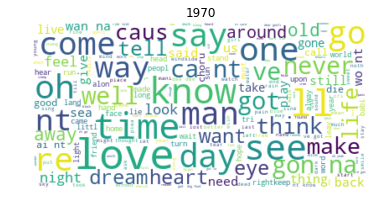

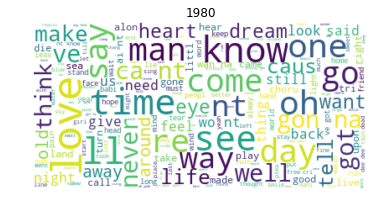

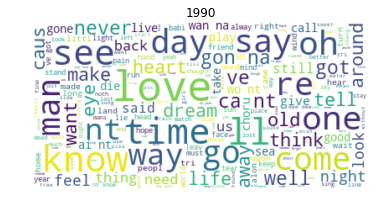

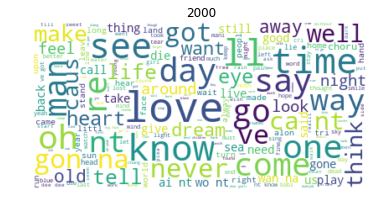

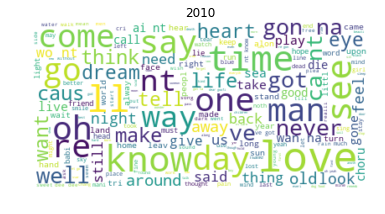

In [66]:
for key in decade_keys:
    decade = decade_groups.get_group(key)
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(' '.join(genre['stemmed lyrics'].tolist()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(key)
    plt.axis("off")
    plt.show()

In [67]:
for key in decade_keys:
    decade = decade_groups.get_group(key)
    texts = [nltk.word_tokenize(song) for song in decade['stemmed lyrics']]
    word_dictionary = corpora.Dictionary(texts)
    for idx, val in enumerate(word_dictionary): word_dictionary[idx]
    dt_matrix = [word_dictionary.doc2bow(text) for text in texts]  # Tuple (Term ID, Term Frequency)
    ldamodel = gensim.models.ldamodel.LdaModel(dt_matrix, num_topics=10, id2word=word_dictionary.id2token, passes=20)
    print("\n[ Decade: ",key," ]")
#     print("[ ldamodel ]")
#     print(ldamodel)
#     print("\n[ ldamodel.print_topics ]")
    pprint.pprint(ldamodel.print_topics())


[ Decade:  1970  ]
[(0,
  '0.023*"s" + 0.013*"like" + 0.012*"red" + 0.011*"away" + 0.008*"run" + '
  '0.008*"see" + 0.008*"keep" + 0.007*"ride" + 0.007*"got" + 0.006*"somebodi"'),
 (1,
  '0.043*"nt" + 0.036*"s" + 0.016*"m" + 0.014*"man" + 0.012*"know" + '
  '0.012*"time" + 0.010*"oh" + 0.009*"ca" + 0.009*"see" + 0.009*"ve"'),
 (2,
  '0.027*"s" + 0.018*"love" + 0.017*"come" + 0.016*"re" + 0.013*"night" + '
  '0.013*"like" + 0.010*"see" + 0.009*"keep" + 0.009*"roll" + 0.008*"know"'),
 (3,
  '0.019*"go" + 0.018*"nt" + 0.018*"s" + 0.015*"let" + 0.015*"re" + '
  '0.014*"take" + 0.013*"come" + 0.013*"know" + 0.013*"back" + 0.013*"lord"'),
 (4,
  '0.032*"s" + 0.026*"nt" + 0.020*"got" + 0.014*"m" + 0.010*"ve" + '
  '0.009*"littl" + 0.009*"oh" + 0.009*"get" + 0.008*"ll" + 0.008*"na"'),
 (5,
  '0.088*"la" + 0.075*"yeah" + 0.049*"oh" + 0.018*"one" + 0.012*"s" + '
  '0.010*"ll" + 0.009*"live" + 0.008*"wake" + 0.006*"five" + 0.006*"danc"'),
 (6,
  '0.036*"s" + 0.024*"get" + 0.014*"nt" + 0.013*"got